Import the necessary datasets and libraries

In [35]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
phishing_websites = fetch_ucirepo(id=327) 
  
# data (as pandas dataframes) 
X = phishing_websites.data.features 
y = phishing_websites.data.targets 
  
# metadata 
#print(phishing_websites.metadata) 
  
# variable information 
#print(phishing_websites.variables) 

In [36]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [37]:
X

,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,rightclick,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,1,-1,-1,-1,-1,1,1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,1,-1,-1,0,-1,1,1,1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,1,-1,1,-1,1,0,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,1,-1,-1,1,-1,1,-1,1
4,1,0,-1,1,1,-1,1,1,-1,1,...,1,-1,1,-1,-1,0,-1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,-1,1,-1,1,1,1,1,-1,-1,...,-1,-1,-1,1,1,-1,-1,1,1,1
11051,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,1,-1,1,1,1,1,1,1,-1,1
11052,1,-1,1,1,1,-1,1,-1,-1,1,...,1,1,1,1,1,1,-1,1,0,1
11053,-1,-1,1,1,1,-1,-1,-1,1,-1,...,1,-1,1,1,1,1,-1,1,1,1


In [38]:
y

,result
0,-1
1,-1
2,-1
3,-1
4,1
...,...
11050,1
11051,-1
11052,-1
11053,-1


Part1: Decision Trees

Split the dataset into training and test sets

In [39]:
y = y.values.ravel()  # If y is a pandas DataFrame
# First split: 60% train, 40% remaining (to be split into validation and test)
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.4, random_state=42)

# Second split: 20% validation, 20% test from the remaining 40%
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

Constructing a Decision Tree

In [40]:
# Create a decision tree classifier with an initial max depth (we'll tune this)
clf = DecisionTreeClassifier(max_depth=3, random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Validate the model using the validation set
y_valid_pred = clf.predict(X_valid)

# Evaluate on the validation set
print("Validation Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("Validation Classification Report:\n", classification_report(y_valid, y_valid_pred))



Validation Accuracy: 0.9099954771596562
Validation Classification Report:
               precision    recall  f1-score   support

          -1       0.90      0.90      0.90       976
           1       0.92      0.92      0.92      1235

    accuracy                           0.91      2211
   macro avg       0.91      0.91      0.91      2211
weighted avg       0.91      0.91      0.91      2211



Decision Tree Visualization

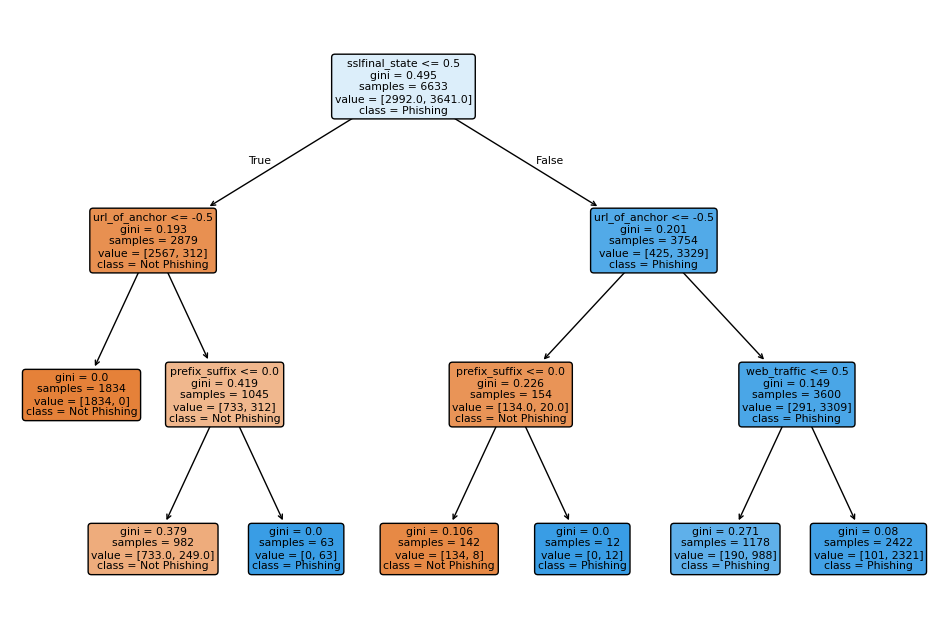

In [41]:
# Plot the final decision tree
plt.figure(figsize=(12, 8))
tree.plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Not Phishing', 'Phishing'], rounded=True)
plt.show()


Step-by-Step Instructions:

1.Check the SSL Certificate State (sslfinal_state) and URL Anchor (url_of_anchor):

If the website does not have a valid SSL certificate (sslfinal_state ≤ 0.5), and the URL anchor is unusually structured (url_of_anchor ≤ -0.5), classify the site as Not Phishing.
If the SSL certificate is invalid (sslfinal_state ≤ 0.5) and the URL anchor appears normal (url_of_anchor > -0.5), proceed to step 2.
If the website does have a valid SSL certificate (sslfinal_state > 0.5), and the URL anchor is unusual (url_of_anchor ≤ -0.5), continue to step 2.
If the website does have a valid SSL certificate (sslfinal_state > 0.5), and the URL anchor appears normal (url_of_anchor > -0.5), classify the site as Phishing.

2.Check for Prefix or Suffix in the URL (prefix_suffix):

If the URL does not contain a suspicious prefix or suffix (prefix_suffix ≤ 0.0), the site is likely Not Phishing.
However, if the URL structure shows a suspicious prefix or suffix (prefix_suffix > 0.0), classify the site as Phishing.


Part 2: Random Forests


1. Train and Tune the Random Forest

In [42]:
# Initialize a random forest classifier
rf = RandomForestClassifier(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


2. Evaluate the Random Forest Model

In [44]:
# Train the random forest with the best parameters
best_rf = grid_search.best_estimator_

# Validate the model
y_valid_pred = best_rf.predict(X_valid)
print("Validation Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("Validation Classification Report:\n", classification_report(y_valid, y_valid_pred))

# Test the model
y_test_pred = best_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))


Validation Accuracy: 0.9638172772501131
Validation Classification Report:
               precision    recall  f1-score   support

          -1       0.97      0.95      0.96       976
           1       0.96      0.98      0.97      1235

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211

Test Accuracy: 0.9710538218000905
Test Classification Report:
               precision    recall  f1-score   support

          -1       0.97      0.96      0.97       930
           1       0.97      0.98      0.98      1281

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211



3. Visualization of Feature Importances

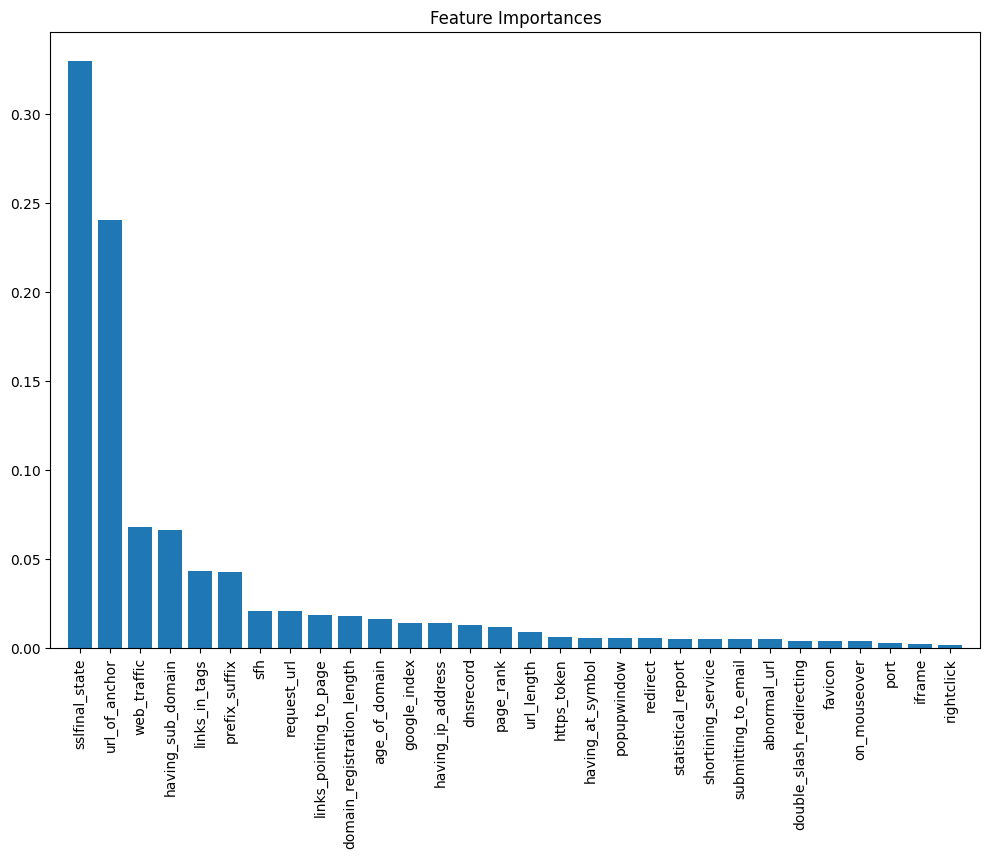

In [45]:
importances = best_rf.feature_importances_
indices = importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()